#Eccentricity Damping & Migration

REBOUNDx (x = eXtras) allows you to easily add additional forces to N-body integrations.  We begin by importing both the rebound and reboundx modules.

In [1]:
import rebound
import reboundx
import numpy as np

Now let's set the integrator to IAS15, G to $4\pi^2$ (so units are in AU, $M_\odot$, and years), and the time of the integration to $10^4$ years.  Then let's add two planets on initially eccentric orbits, and move to the center of mass frame.

In [2]:
sim = rebound.Simulation()
sim.integrator = "whfast"
sim.G = 4*np.pi**2
tmax = 1.e4 # years
e0 = 0.1
ainner = 1.
aouter = 10.

sim.add(m=1.)
sim.add(m=1e-6,a=ainner,e=e0)
sim.add(m=1e-6,a=aouter,e=e0)
sim.move_to_com() # Moves to the center of momentum frame

To use reboundx, we create a `reboundx.Extras` instance, and pass it the simulation we want to modify:

In [3]:
rebx = reboundx.Extras(sim)

We then add the modification we are interested in.  For modifying orbital elements, there are two flavors, both of which exponentially decrease/increase the semimajor axis and eccentricity on a timescale $\tau$.  `modify_orbits_direct` directly calculates orbital elements and modifies those, while `modify_orbits_forces` applies forces that when orbit-averaged yield the exponential behavior.  We are currently working on a paper that considers when each one might be more appropriate.

We select either one by calling the appropriate function, and then we set the appropriate e-folding timescales for each planet's semimajor axis and/or eccentricity.  **Positive values correspond to exponential increases, negative ones to exponential damping.**  The `reboundx.Extras` instance has a member with the same name as used to add the modification, which holds arrays for the timescales:

In [ ]:
rebx.add_modify_orbits_forces()
rebx.modify_orbits_forces.tau_e[1] = -tmax/10. # this is for particles[1]
rebx.modify_orbits_forces.tau_e[2] = -tmax     # this is for particles[2]

Now we have to turn on reboundx for the given simulation, and we set the damping/migration parameters.

The first line is always required to tell rebound to use reboundxf for additional forces.  Eccentricity damping and migration are implemented as forces that lead to an orbit-averaged exponential decay 
\begin{equation}
a = a_0e^{-t/\tau_a},\:\:\:e = e_0e^{-t/\tau_e}
\end{equation}
In general, each body will have different damping timescales.  To implement, simply call the above setter functions with a list containing the e-damping (or migration) timescales for each of the bodies, in the same order they were added to the simulation.

**Important:** Currently you must only set damping timescales **AFTER** all the particles have been added to the simulation, and this implementation does not support adding or removing particles in the middle of the simulation (e.g. during collisions or particles leaving the box)

Now let's integrate, and keep track of the two planets' eccentricities and semimajor axes to test this.

In [4]:
Nout = 1000
e1,e2,a1,a2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0.,tmax,Nout)
for i,time in enumerate(times):
    sim.integrate(time)
    orbits = sim.calculate_orbits() # returns an array of orbits, where the 0 element is the first *PLANET*
    e1[i] = orbits[0].e
    e2[i] = orbits[1].e
    a1[i] = orbits[0].a
    a2[i] = orbits[1].a

Now let's plot it on a linear-log scale to check whether we get the expected exponential behavior.  We'll also overplot the expected exponential decays for comparison.

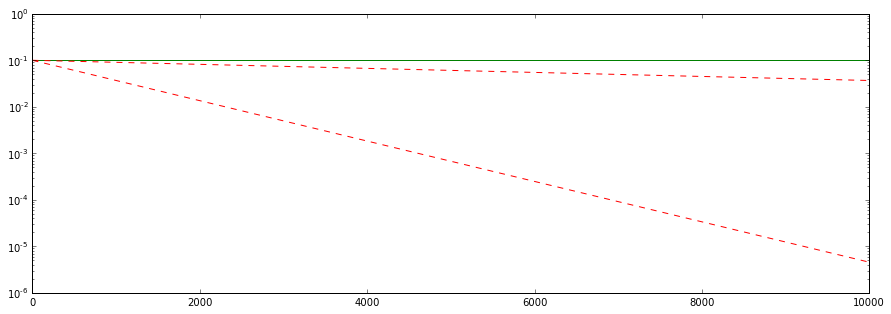

In [5]:
e1pred = [e0*np.e**(-t/taues[1]) for t in times]
e2pred = [e0*np.e**(-t/taues[2]) for t in times]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,e1)
plt.plot(times,e1pred, 'r--')
plt.plot(times,e2)
plt.plot(times,e2pred, 'r--')

Hm...I'm looking into this behavior.  Plotting the semimajor axes,

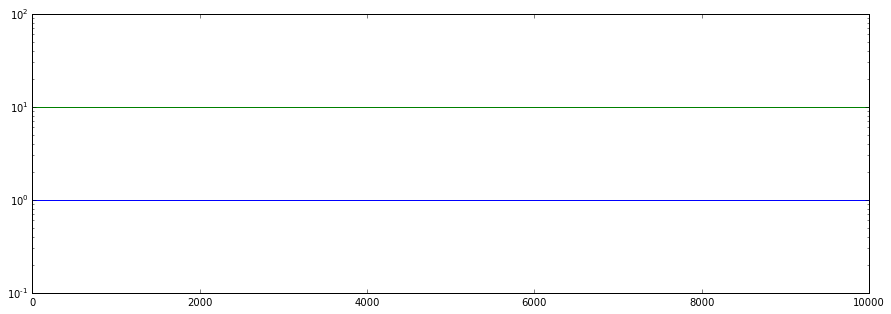

In [6]:
#a2pred = [aouter*np.e**(-t/tauas[2]) for t in times]

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,a1)
plt.plot(times,a2)
#plt.plot(times,a2pred, 'r--')